# **Data Description**

The dataset contains concrete images having cracks. The data is collected from various METU Campus Buildings.
The dataset is divided into two as negative and positive crack images for image classification.
Each class has 20000images with a total of 40000 images with 227 x 227 pixels with RGB channels.
The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016).
High-resolution images have variance in terms of surface finish and illumination conditions.
No data augmentation in terms of random rotation or flipping is applied.

# **Data Gathering**

In [ ]:
!unzip concrete_crack_dataset.zip -d cracks_raw

Streaming output truncated to the last 5000 lines.
  inflating: cracks_raw/negative/15001.jpg  
  inflating: cracks_raw/negative/15002.jpg  
  inflating: cracks_raw/negative/15003.jpg  
  inflating: cracks_raw/negative/15004.jpg  
  inflating: cracks_raw/negative/15005.jpg  
  inflating: cracks_raw/negative/15006.jpg  
  inflating: cracks_raw/negative/15007.jpg  
  inflating: cracks_raw/negative/15008.jpg  
  inflating: cracks_raw/negative/15009.jpg  
  inflating: cracks_raw/negative/15010.jpg  
  inflating: cracks_raw/negative/15011.jpg  
  inflating: cracks_raw/negative/15012.jpg  
  inflating: cracks_raw/negative/15013.jpg  
  inflating: cracks_raw/negative/15014.jpg  
  inflating: cracks_raw/negative/15015.jpg  
  inflating: cracks_raw/negative/15016.jpg  
  inflating: cracks_raw/negative/15017.jpg  
  inflating: cracks_raw/negative/15018.jpg  
  inflating: cracks_raw/negative/15019.jpg  
  inflating: cracks_raw/negative/15020.jpg  
  inflating: cracks_raw/negative/15021.jpg  
  in

In [ ]:
# Import libraries

import os
import warnings
warnings.filterwarnings('ignore')
import cv2
import random
from joblib import Parallel, delayed
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalAveragePooling2D, Lambda

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Collect data
negative_dir = '/content/cracks_raw/negative'
positive_dir = '/content/cracks_raw/positive'

In [ ]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.jpg') or img_path.endswith('.png'):
            img = Image.open(img_path)
            images.append(img)
    return images

In [ ]:
negative_images = load_images(negative_dir)
positive_images = load_images(positive_dir)

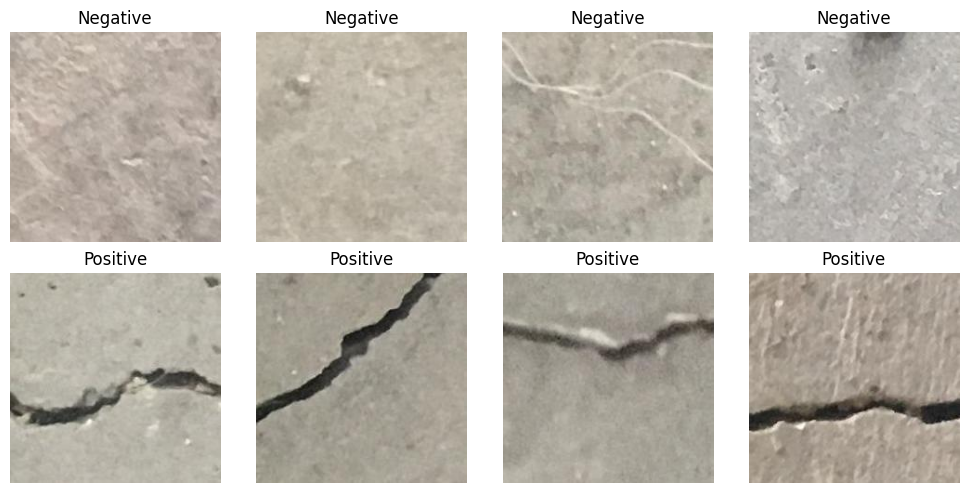

In [ ]:
# Display samples of Negative and Positive Concrete Cracks
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(negative_images[i])
    plt.axis('off')
    plt.title('Negative')

    plt.subplot(2, 4, i + 5)
    plt.imshow(positive_images[i])
    plt.axis('off')
    plt.title('Positive')

plt.tight_layout()
plt.show()

# **Preprocessing**

In [ ]:
img_size = (224, 224)

# Create data generators
data_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_gen = data_gen.flow_from_directory(
    '/content/cracks_raw',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = data_gen.flow_from_directory(
    '/content/cracks_raw',
    target_size=img_size,
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
def load_images_with_edges(folder, size=(112, 112)):
    images = []
    edges = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.jpg') or img_path.endswith('.png'):
            img = Image.open(img_path)
            img = img.resize(size)
            img_array = np.array(img)
            gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

            # Perform Canny edge detection
            edge_img = cv2.Canny(gray_img, threshold1=100, threshold2=200)

            # Convert edge image back to PIL for visualization
            edges.append(Image.fromarray(edge_img))
            images.append(img)
    return images, edges

In [ ]:
negative_images, negative_edges = load_images_with_edges(negative_dir)
positive_images, positive_edges = load_images_with_edges(positive_dir)

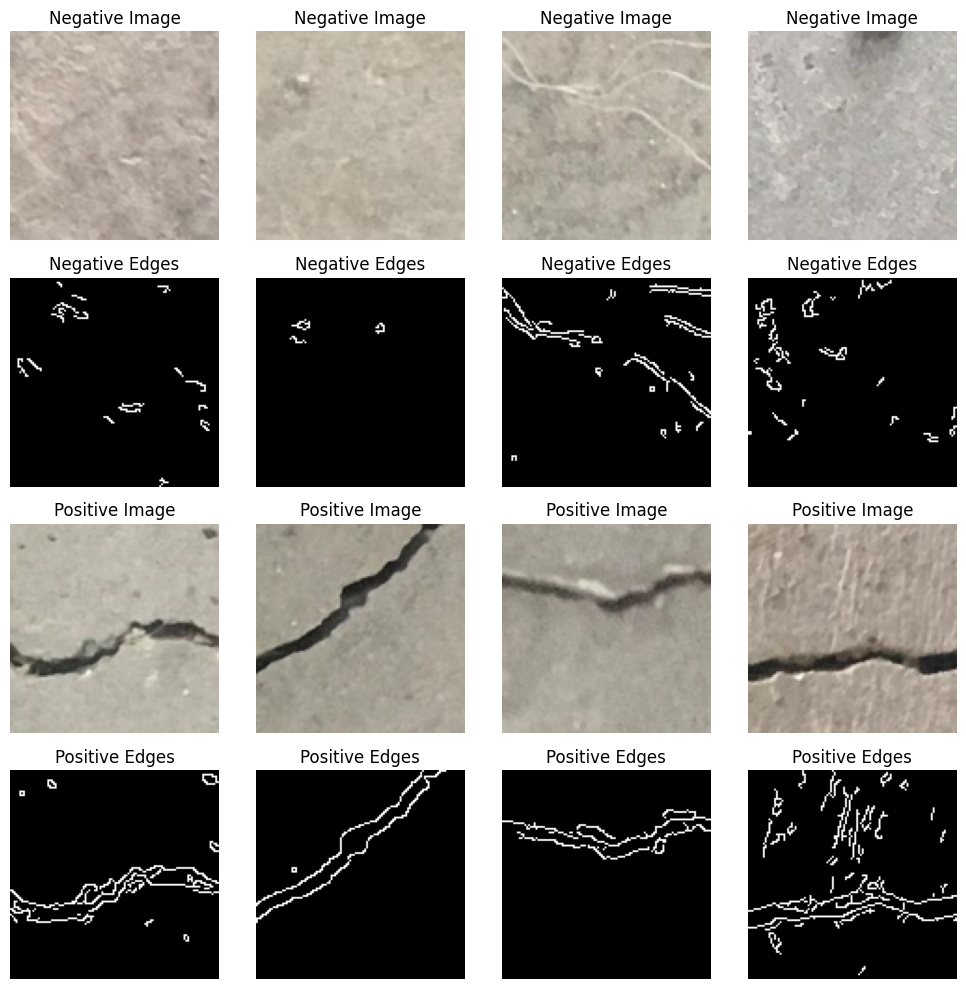

In [ ]:
# Visualize edges for Concrete
plt.figure(figsize=(10, 10))
for i in range(4):
    # Original negative images
    plt.subplot(4, 4, i + 1)
    plt.imshow(negative_images[i])
    plt.axis('off')
    plt.title('Negative Image')

    # Canny edges for negative images
    plt.subplot(4, 4, i + 5)
    plt.imshow(negative_edges[i], cmap='gray')
    plt.axis('off')
    plt.title('Negative Edges')

    # Original positive images
    plt.subplot(4, 4, i + 9)
    plt.imshow(positive_images[i])
    plt.axis('off')
    plt.title('Positive Image')

    # Canny edges for positive images
    plt.subplot(4, 4, i + 13)
    plt.imshow(positive_edges[i], cmap='gray')
    plt.axis('off')
    plt.title('Positive Edges')

plt.tight_layout()
plt.show()

# **CNN Model**

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 59ms/step - accuracy: 0.9213 - loss: 0.1920 - val_accuracy: 0.9214 - val_loss: 0.2984
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9680 - loss: 0.0986 - val_accuracy: 0.9933 - val_loss: 0.0199
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9918 - loss: 0.0249 - val_accuracy: 0.9929 - val_loss: 0.0207
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.9883 - val_loss: 0.0430
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9919 - loss: 0.0254 - val_accuracy: 0.9966 - val_loss: 0.0124
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - accuracy: 0.9948 - loss: 0.0179 - val_accuracy: 0.9961 - val_loss: 0.0146
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9964 - loss: 0.0132 - val_accuracy: 0.9934 - val_loss: 0.0185
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.9931 -

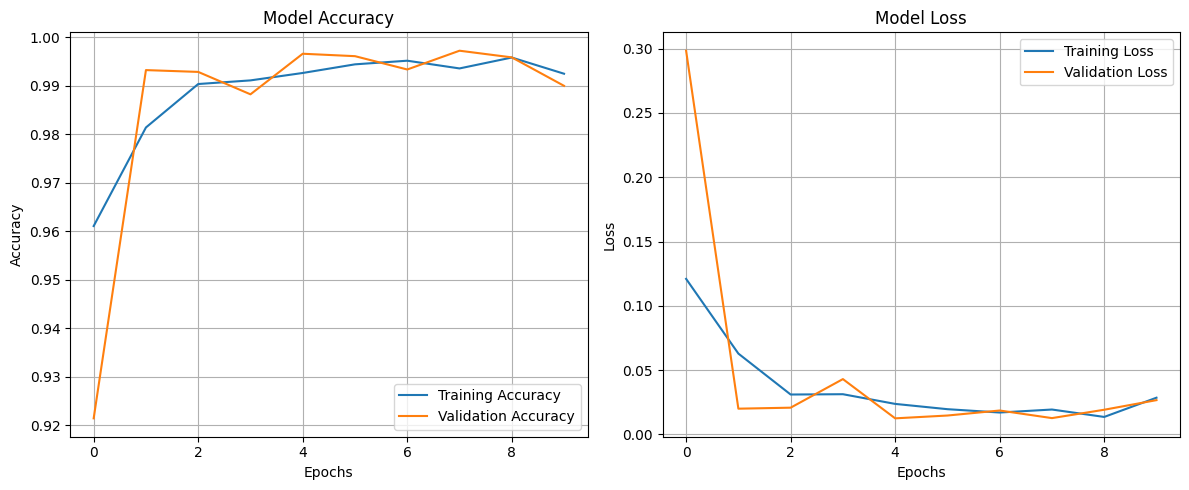

In [ ]:
# Visualize accuracy and model loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# **Pretrained Model**

In [ ]:
# Extract deep features using the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, epochs=10, validation_data=val_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 242s 228ms/step - accuracy: 0.9564 - loss: 0.1390 - val_accuracy: 0.9944 - val_loss: 0.0219
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9943 - loss: 0.0190 - val_accuracy: 0.9952 - val_loss: 0.0142
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9979 - val_loss: 0.0092
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9957 - loss: 0.0143 - val_accuracy: 0.9966 - val_loss: 0.0109
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9961 - loss: 0.0128 - val_accuracy: 0.9970 - val_loss: 0.0115
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9963 - loss: 0.0124 - val_accuracy: 0.9976 - val_loss: 0.0088
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 228s 228ms/step - accuracy: 0.9964 - loss: 0.0110 - val_accuracy: 0.9980 - val_loss: 0.0072
Epoch 8/10


In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.2f}')

250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9989 - loss: 0.0053
Validation accuracy: 1.00


# **Prediction**

In [ ]:
def predict_image(img_path):
    img = Image.open(img_path)
    img = img.resize(img_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    return 'Positive' if prediction[0][0] > 0.5 else 'Negative'

# Example prediction (by positive crack)
print(predict_image('/content/cracks_raw/positive/00004.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Positive


In [ ]:
# Example prediction (by negative crack)
print(predict_image('/content/cracks_raw/negative/00002.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Negative


In [ ]:
# =========================
# 1) DATA PREP
#    Expect RAW_DIR/positive and RAW_DIR/negative
# =========================
# TODO: แก้พาธนี้ให้ชี้ไปยังที่คุณวางรูปภาพ (มี positive/negative อยู่ข้างใน)
import os, shutil, random, glob, json
from pathlib import Path
RAW_DIR = Path("/content/cracks_raw")  # <--- เปลี่ยนตรงนี้

# จะสร้างชุดข้อมูลใหม่ที่นี่
DATASET_DIR = Path("/content/crack_dataset_cls")
SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)

assert (RAW_DIR/'positive').exists() and (RAW_DIR/'negative').exists(), "ไม่พบโฟลเดอร์ positive/negative ใน RAW_DIR"

# สร้างโครงสร้าง train/val/test / (crack|no_crack)
for split in ['train','val','test']:
    for cls in ['crack','no_crack']:
        (DATASET_DIR/split/cls).mkdir(parents=True, exist_ok=True)

# รวบรวมไฟล์
pos_files = sorted([p for p in (RAW_DIR/'positive').rglob('*') if p.suffix.lower() in ['.jpg','.jpeg','.png','.bmp','.tif','.tiff']])
neg_files = sorted([p for p in (RAW_DIR/'negative').rglob('*') if p.suffix.lower() in ['.jpg','.jpeg','.png','.bmp','.tif','.tiff']])

# def split_list(files, train_ratio=0.7, val_ratio=0.15):
#     n = len(files)
#     idx = np.arange(n)
#     np.random.shuffle(idx)
#     n_train = int(n*train_ratio)
#     n_val = int(n*val_ratio)
#     train_idx = idx[:n_train]
#     val_idx = idx[n_train:n_train+n_val]
#     test_idx = idx[n_train+n_val:]
#     return [files[i] for i in train_idx], [files[i] for i in val_idx], [files[i] for i in test_idx]

def split_list(files, train_ratio=0.7, val_ratio=0.15, seed=42):
    files = list(files)
    rnd = random.Random(seed)
    rnd.shuffle(files)
    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = files[:n_train]
    val = files[n_train:n_train + n_val]
    test = files[n_train + n_val:]
    return train, val, test

pos_tr, pos_val, pos_te = split_list(pos_files)
neg_tr, neg_val, neg_te = split_list(neg_files)

def copy_files(files, dst_dir):
    for f in files:
        dst = dst_dir/f.name
        # ป้องกันชื่อชนกัน
        stem, ext = f.stem, f.suffix
        k = 1
        while dst.exists():
            dst = dst_dir/f"{stem}_{k}{ext}"
            k += 1
        shutil.copy2(f, dst)

copy_files(pos_tr, DATASET_DIR/'train'/'crack')
copy_files(pos_val, DATASET_DIR/'val'/'crack')
copy_files(pos_te, DATASET_DIR/'test'/'crack')

copy_files(neg_tr, DATASET_DIR/'train'/'no_crack')
copy_files(neg_val, DATASET_DIR/'val'/'no_crack')
copy_files(neg_te, DATASET_DIR/'test'/'no_crack')

print("Dataset prepared at:", DATASET_DIR)
for split in ['train','val','test']:
    n_pos = len(list((DATASET_DIR/split/'crack').glob('*')))
    n_neg = len(list((DATASET_DIR/split/'no_crack').glob('*')))
    print(f"{split:5s} -> crack={n_pos}, no_crack={n_neg}")


Dataset prepared at: /content/crack_dataset_cls
train -> crack=14000, no_crack=14000
val   -> crack=3000, no_crack=3000
test  -> crack=3000, no_crack=3000


train -> crack=14000, no_crack=14000
val   -> crack=3000, no_crack=3000
test  -> crack=3000, no_crack=3000
Classes: ['crack', 'no_crack']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


[Epoch 01] Train: loss=0.0320, acc=0.9904, P/R/F1=0.9933/0.9875/0.9904 | Val: loss=0.0089, acc=0.9977, P/R/F1=0.9977/0.9977/0.9977 | time=65.2s
[Epoch 02] Train: loss=0.0124, acc=0.9963, P/R/F1=0.9971/0.9954/0.9963 | Val: loss=0.0138, acc=0.9963, P/R/F1=0.9963/0.9963/0.9963 | time=64.3s
[Epoch 03] Train: loss=0.0145, acc=0.9958, P/R/F1=0.9968/0.9947/0.9957 | Val: loss=0.0085, acc=0.9983, P/R/F1=0.9973/0.9993/0.9983 | time=64.8s
[Epoch 04] Train: loss=0.0115, acc=0.9968, P/R/F1=0.9971/0.9964/0.9967 | Val: loss=0.0074, acc=0.9980, P/R/F1=0.9987/0.9973/0.9980 | time=66.0s
[Epoch 05] Train: loss=0.0108, acc=0.9966, P/R/F1=0.9971/0.9961/0.9966 | Val: loss=0.0083, acc=0.9980, P/R/F1=0.9967/0.9993/0.9980 | time=65.9s
[Epoch 06] Train: loss=0.0099, acc=0.9974, P/R/F1=0.9980/0.9969/0.9974 | Val: loss=0.0219, acc=0.9945, P/R/F1=0.9898/0.9993/0.9945 | time=66.4s
[Epoch 07] Train: loss=0.0074, acc=0.9979, P/R/F1=0.9983/0.9976/0.9979 | Val: loss=0.0061, acc=0.9982, P/R/F1=0.9977/0.9987/0.9982 | tim

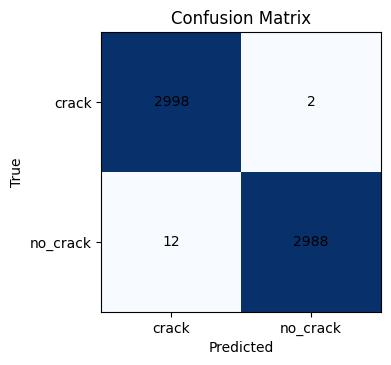

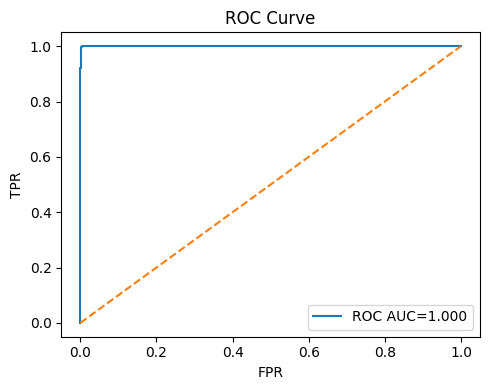

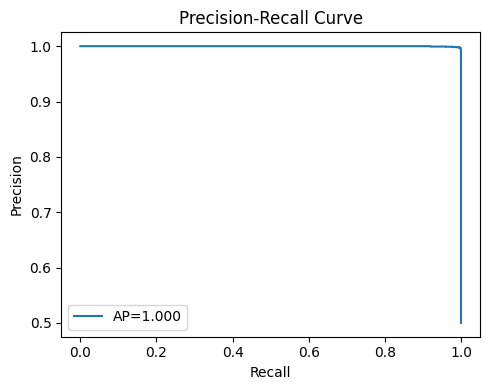


Sample predictions:
{'file': '/content/crack_dataset_cls/dataset/test/crack/19790.jpg', 'pred_class': 'crack', 'prob_crack': 1.0, 'prob_no_crack': 2.0314191301329387e-11}
{'file': '/content/crack_dataset_cls/dataset/test/no_crack/19790.jpg', 'pred_class': 'no_crack', 'prob_crack': 0.0006480147130787373, 'prob_no_crack': 0.9993520379066467}


In [ ]:
# ============================================================
# Concrete Crack Classification (CNN) — Colab/Local Ready
# - Dataset input: RAW_DIR/{positive, negative}
# - Split: train/val/test
# - Models: (A) ResNet18 transfer learning (default) or (B) Custom CNN
# - Metrics: Accuracy, Precision, Recall, F1, ROC-AUC + Confusion Matrix
# - Plots: ROC curve, PR curve, Confusion Matrix heatmap
# ============================================================

# If needed (Colab), uncomment:
# !pip -q install torch torchvision torchaudio scikit-learn matplotlib

import os, shutil, random, math, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support,
                             roc_auc_score, roc_curve, average_precision_score,
                             classification_report, precision_recall_curve)

# ----------------------
# CONFIG
# ----------------------
RAW_DIR = Path("/content/cracks_raw")   # <-- เปลี่ยนให้ตรงตำแหน่งจริง (มี positive/negative อยู่ข้างใน)
WORK_DIR = Path("/content/crack_dataset_cls")
DATASET_DIR = WORK_DIR/"dataset"
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3
USE_RESNET18 = True   # True=ใช้ ResNet18 (CNN), False=ใช้ custom CNN
PATIENCE = 5          # early stopping by val F1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# REPRODUCIBILITY
# ----------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ----------------------
# SANITY CHECK
# ----------------------
assert (RAW_DIR/'positive').exists() and (RAW_DIR/'negative').exists(), \
    f"ไม่พบ positive/negative ภายใต้ {RAW_DIR}"

# ----------------------
# SPLIT & PREP DATA
# ----------------------
def split_list(files, train_ratio=0.7, val_ratio=0.15, seed=SEED):
    files = list(files)
    rnd = random.Random(seed)
    rnd.shuffle(files)
    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = files[:n_train]
    val = files[n_train:n_train + n_val]
    test = files[n_train + n_val:]
    return train, val, test

def copy_files(filepaths, dst_dir):
    dst_dir.mkdir(parents=True, exist_ok=True)
    seen = set()
    for p in filepaths:
        name = p.name
        stem, ext = p.stem, p.suffix
        k = 1
        while name in seen or (dst_dir/name).exists():
            name = f"{stem}_{k}{ext}"
            k += 1
        shutil.copy2(p, dst_dir/name)
        seen.add(name)

# Collect images
def is_img(p: Path):
    return p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

pos_files = sorted([p for p in (RAW_DIR/'positive').rglob("*") if p.is_file() and is_img(p)])
neg_files = sorted([p for p in (RAW_DIR/'negative').rglob("*") if p.is_file() and is_img(p)])

pos_tr, pos_val, pos_te = split_list(pos_files)
neg_tr, neg_val, neg_te = split_list(neg_files)

# Rebuild dataset dir
if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
for split in ["train","val","test"]:
    for cls in ["crack", "no_crack"]:
        (DATASET_DIR/split/cls).mkdir(parents=True, exist_ok=True)

copy_files(pos_tr, DATASET_DIR/"train"/"crack")
copy_files(pos_val, DATASET_DIR/"val"/"crack")
copy_files(pos_te, DATASET_DIR/"test"/"crack")
copy_files(neg_tr, DATASET_DIR/"train"/"no_crack")
copy_files(neg_val, DATASET_DIR/"val"/"no_crack")
copy_files(neg_te, DATASET_DIR/"test"/"no_crack")

for split in ["train","val","test"]:
    n_pos = len(list((DATASET_DIR/split/"crack").glob("*")))
    n_neg = len(list((DATASET_DIR/split/"no_crack").glob("*")))
    print(f"{split:5s} -> crack={n_pos}, no_crack={n_neg}")

# ----------------------
# DATASETS & DATALOADERS
# ----------------------
# ImageNet normalization (เหมาะกับ backbone ที่ pretrain มาจาก ImageNet)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.ImageFolder(root=str(DATASET_DIR/"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(root=str(DATASET_DIR/"val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(root=str(DATASET_DIR/"test"),  transform=eval_tfms)

classes = train_ds.classes  # ['crack', 'no_crack']
print("Classes:", classes)
pos_label_name = "crack"
pos_idx = classes.index(pos_label_name)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ----------------------
# MODEL
# ----------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def build_model(num_classes=2, use_resnet18=True):
    if use_resnet18:
        try:
            weights = models.ResNet18_Weights.IMAGENET1K_V1
            m = models.resnet18(weights=weights)
        except:
            m = models.resnet18(pretrained=True)
        in_feats = m.fc.in_features
        m.fc = nn.Linear(in_feats, num_classes)
        return m
    else:
        return SmallCNN(num_classes=num_classes)

model = build_model(num_classes=2, use_resnet18=USE_RESNET18).to(DEVICE)

# ----------------------
# LOSS (class weights for imbalance)
# ----------------------
# compute class weights from train set
counts = np.bincount([y for _, y in train_ds.samples])
weights = (counts.sum() / (2.0 * counts)).astype(np.float32)  # inverse freq
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ----------------------
# TRAIN / EVAL HELPERS
# ----------------------
def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    losses, all_preds, all_labels = [], [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        losses.append(loss.detach().item())
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_labels.extend(labels.detach().cpu().numpy().tolist())

    # metrics
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds,
                                                       average='binary', pos_label=pos_idx, zero_division=0)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    return float(np.mean(losses)), acc, prec, rec, f1

def evaluate_full(loader):
    model.eval()
    all_labels, all_preds, all_probs_pos = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
            all_probs_pos.extend(probs[:, pos_idx].cpu().numpy().tolist())

    cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds,
                                                       average='binary', pos_label=pos_idx, zero_division=0)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    try:
        auc = roc_auc_score((np.array(all_labels)==pos_idx).astype(int), all_probs_pos)
    except:
        auc = float('nan')
    ap = average_precision_score((np.array(all_labels)==pos_idx).astype(int), all_probs_pos)
    report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
    return {
        "acc": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc, "avg_precision": ap,
        "cm": cm, "y_true": np.array(all_labels), "y_pred": np.array(all_preds), "y_prob": np.array(all_probs_pos),
        "report": report
    }

# ----------------------
# TRAINING LOOP with Early Stopping on val F1
# ----------------------
best_f1 = -1.0
best_state = None
epochs_no_improve = 0

for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_p, tr_r, tr_f1 = run_epoch(train_loader, train_mode=True)
    va_loss, va_acc, va_p, va_r, va_f1 = run_epoch(val_loader, train_mode=False)
    scheduler.step(va_f1)

    print(f"[Epoch {ep:02d}] "
          f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}, P/R/F1={tr_p:.4f}/{tr_r:.4f}/{tr_f1:.4f} | "
          f"Val: loss={va_loss:.4f}, acc={va_acc:.4f}, P/R/F1={va_p:.4f}/{va_r:.4f}/{va_f1:.4f} | "
          f"time={time.time()-t0:.1f}s")

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {ep} (no val F1 improvement for {PATIENCE} epochs)")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ----------------------
# TEST EVALUATION
# ----------------------
res = evaluate_full(test_loader)
print("\n=== Test Metrics ===")
print(f"Accuracy    : {res['acc']:.4f}")
print(f"Precision   : {res['precision']:.4f}")
print(f"Recall      : {res['recall']:.4f}")
print(f"F1-score    : {res['f1']:.4f}")
print(f"ROC-AUC     : {res['roc_auc']:.4f}")
print(f"AvgPrecision(PR AUC): {res['avg_precision']:.4f}")
print("\nClassification Report:\n", res["report"])
print("Confusion Matrix (rows=true, cols=pred):\n", res["cm"])

# ----------------------
# PLOTS: Confusion Matrix, ROC, PR
# ----------------------
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names, rotation=0)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

def plot_roc_pr(y_true, y_prob, pos_label=1):
    y_bin = (y_true == pos_label).astype(int)
    fpr, tpr, _ = roc_curve(y_bin, y_prob)
    prec, rec, _ = precision_recall_curve(y_bin, y_prob)

    # ROC
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc_score(y_bin, y_prob):.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

    # PR
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"AP={average_precision_score(y_bin, y_prob):.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.tight_layout(); plt.show()

plot_confusion_matrix(res["cm"], classes)
plot_roc_pr(res["y_true"], res["y_prob"], pos_label=pos_idx)

# ----------------------
# SIMPLE INFERENCE DEMO
# ----------------------
from PIL import Image

def predict_image(image_path: str):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = probs.argmax()
    return {"file": image_path, "pred_class": classes[pred], "prob_crack": float(probs[pos_idx]), "prob_no_crack": float(probs[1-pos_idx])}

# ตัวอย่างเลือกภาพจาก test set มาลองทำนาย
sample_paths = []
for p in (DATASET_DIR/"test"/"crack").glob("*"):
    sample_paths.append(str(p));
    if len(sample_paths) >= 1: break
for p in (DATASET_DIR/"test"/"no_crack").glob("*"):
    sample_paths.append(str(p));
    if len(sample_paths) >= 2: break

print("\nSample predictions:")
for sp in sample_paths:
    print(predict_image(sp))


train -> crack=14000, no_crack=14000
val   -> crack=3000, no_crack=3000
test  -> crack=3000, no_crack=3000
[Epoch 01] Train loss=0.0903 acc=0.9696 P/R/F1=0.9739/0.9651/0.9695 | Val loss=0.0314 acc=0.9905 P/R/F1=0.9877/0.9933/0.9905 | time=63.4s
[Epoch 02] Train loss=0.0430 acc=0.9871 P/R/F1=0.9896/0.9846/0.9871 | Val loss=0.0300 acc=0.9908 P/R/F1=0.9976/0.9840/0.9908 | time=63.6s
[Epoch 03] Train loss=0.0325 acc=0.9899 P/R/F1=0.9924/0.9874/0.9899 | Val loss=0.0214 acc=0.9942 P/R/F1=0.9914/0.9970/0.9942 | time=64.4s
[Epoch 04] Train loss=0.0261 acc=0.9924 P/R/F1=0.9931/0.9916/0.9924 | Val loss=0.0154 acc=0.9962 P/R/F1=0.9983/0.9940/0.9962 | time=64.8s
[Epoch 05] Train loss=0.0213 acc=0.9939 P/R/F1=0.9954/0.9923/0.9938 | Val loss=0.0137 acc=0.9972 P/R/F1=0.9993/0.9950/0.9972 | time=64.3s
[Epoch 06] Train loss=0.0174 acc=0.9950 P/R/F1=0.9965/0.9936/0.9950 | Val loss=0.0112 acc=0.9972 P/R/F1=0.9973/0.9970/0.9972 | time=62.6s
[Epoch 07] Train loss=0.0178 acc=0.9949 P/R/F1=0.9964/0.9934/0.99

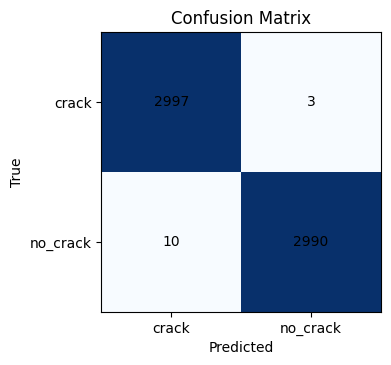

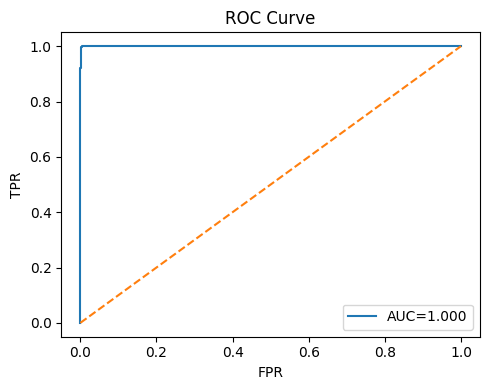

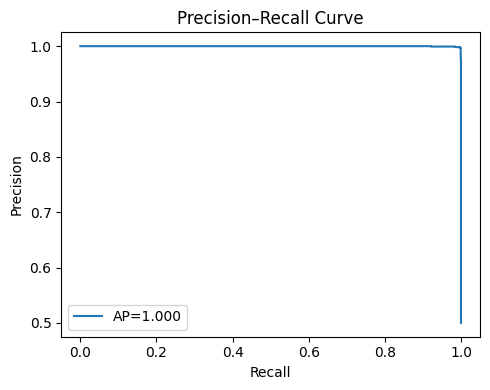


Sample predictions:
{'file': '/content/crack_dataset_cls/dataset/test/crack/19790.jpg', 'pred_class': 'crack', 'prob_crack': 0.9999809265136719, 'prob_no_crack': 1.9052688003284857e-05}
{'file': '/content/crack_dataset_cls/dataset/test/no_crack/19790.jpg', 'pred_class': 'no_crack', 'prob_crack': 3.586625462048687e-05, 'prob_no_crack': 0.9999641180038452}


In [ ]:
# ============================================================
# Concrete Crack Classification with CNN + BiLSTM (RNN)
# - Input: RAW_DIR/{positive, negative}
# - Split: 70/15/15 train/val/test
# - Model: CNN stem -> AdaptiveAvgPool(H_seq, W_seq) -> BiLSTM -> FC
# - Metrics: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC, Confusion Matrix
# ============================================================

# !pip -q install torch torchvision scikit-learn matplotlib  # (ถ้ายังไม่มี)

import os, shutil, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support,
                             roc_auc_score, roc_curve, average_precision_score,
                             classification_report, precision_recall_curve)
from PIL import Image

# ----------------------
# CONFIG
# ----------------------
RAW_DIR = Path("/content/cracks_raw")   # <-- เปลี่ยนให้ตรงตำแหน่งจริง
WORK_DIR = Path("/content/crack_dataset_cls")
DATASET_DIR = WORK_DIR/"dataset"
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RNN grid size (หลัง CNN จะ AdaptiveAvgPool เป็นขนาดนี้)
H_SEQ, W_SEQ = 8, 16        # sequence length = W_SEQ; LSTM input_size = C*H_SEQ
LSTM_HIDDEN = 256
LSTM_LAYERS = 2
BIDIR = True
DROPOUT = 0.3

# ----------------------
# REPRO
# ----------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ----------------------
# CHECK DATA
# ----------------------
assert (RAW_DIR/'positive').exists() and (RAW_DIR/'negative').exists(), \
    f"Not found: {RAW_DIR}/positive and /negative"

# ----------------------
# SPLIT & PREP DATA
# ----------------------
def split_list(files, train_ratio=0.7, val_ratio=0.15, seed=SEED):
    files = list(files)
    rnd = random.Random(seed)
    rnd.shuffle(files)
    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = files[:n_train]
    val = files[n_train:n_train + n_val]
    test = files[n_train + n_val:]
    return train, val, test

def copy_files(filepaths, dst_dir):
    dst_dir.mkdir(parents=True, exist_ok=True)
    seen = set()
    for p in filepaths:
        name, stem, ext = p.name, p.stem, p.suffix
        k = 1
        while name in seen or (dst_dir/name).exists():
            name = f"{stem}_{k}{ext}"
            k += 1
        shutil.copy2(p, dst_dir/name)
        seen.add(name)

def is_img(p: Path):
    return p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}

pos_files = sorted([p for p in (RAW_DIR/'positive').rglob("*") if p.is_file() and is_img(p)])
neg_files = sorted([p for p in (RAW_DIR/'negative').rglob("*") if p.is_file() and is_img(p)])

pos_tr, pos_val, pos_te = split_list(pos_files)
neg_tr, neg_val, neg_te = split_list(neg_files)

if DATASET_DIR.exists():
    shutil.rmtree(DATASET_DIR)
for split in ["train","val","test"]:
    for cls in ["crack", "no_crack"]:
        (DATASET_DIR/split/cls).mkdir(parents=True, exist_ok=True)

copy_files(pos_tr, DATASET_DIR/"train"/"crack")
copy_files(pos_val, DATASET_DIR/"val"/"crack")
copy_files(pos_te, DATASET_DIR/"test"/"crack")
copy_files(neg_tr, DATASET_DIR/"train"/"no_crack")
copy_files(neg_val, DATASET_DIR/"val"/"no_crack")
copy_files(neg_te, DATASET_DIR/"test"/"no_crack")

for split in ["train","val","test"]:
    n_pos = len(list((DATASET_DIR/split/"crack").glob("*")))
    n_neg = len(list((DATASET_DIR/split/"no_crack").glob("*")))
    print(f"{split:5s} -> crack={n_pos}, no_crack={n_neg}")

# ----------------------
# DATASETS & LOADERS
# ----------------------
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_ds = datasets.ImageFolder(root=str(DATASET_DIR/"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(root=str(DATASET_DIR/"val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(root=str(DATASET_DIR/"test"),  transform=eval_tfms)

classes = train_ds.classes  # ['crack', 'no_crack']
pos_idx = classes.index("crack")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# ----------------------
# MODEL: CNN stem -> BiLSTM -> FC
# ----------------------
class CNNBiLSTM(nn.Module):
    def __init__(self, num_classes=2,
                 h_seq=H_SEQ, w_seq=W_SEQ,
                 lstm_hidden=LSTM_HIDDEN, lstm_layers=LSTM_LAYERS,
                 bidir=BIDIR, p_drop=DROPOUT):
        super().__init__()
        # CNN stem (เบาและเร็ว)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 224->112
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 112->56
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 56->28
        )
        # บังคับเป็นขนาดคงที่สำหรับ RNN
        self.pool = nn.AdaptiveAvgPool2d((h_seq, w_seq))  # (C=128, H=h_seq, W=w_seq)
        input_size = 128 * h_seq                           # ฟีเจอร์ต่อ timestep
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_hidden,
                            num_layers=lstm_layers,
                            batch_first=True,
                            bidirectional=bidir,
                            dropout=p_drop if lstm_layers > 1 else 0.0)
        rnn_out = lstm_hidden * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(rnn_out, 128), nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: [B,3,H,W]
        f = self.cnn(x)                 # [B,128,H',W']
        f = self.pool(f)                # [B,128,h_seq,w_seq]
        B,C,Hs,Ws = f.shape
        # time steps = W_seq; token dim = C*H_seq
        seq = f.permute(0,3,1,2).contiguous().view(B, Ws, C*Hs)  # [B,Ws,C*Hs]
        out, _ = self.lstm(seq)         # [B,Ws,rnn_out]
        last = out[:, -1, :]            # ใช้ timestep สุดท้าย (จะเปลี่ยนเป็น mean pooling ก็ได้)
        logits = self.head(last)        # [B,num_classes]
        return logits

model = CNNBiLSTM(num_classes=2).to(DEVICE)

# ----------------------
# LOSS / OPT / SCHED
# ----------------------
counts = np.bincount([y for _, y in train_ds.samples])
weights = (counts.sum() / (2.0 * counts)).astype(np.float32)  # inverse freq
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# ----------------------
# TRAIN / EVAL HELPERS
# ----------------------
def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    losses, all_preds, all_labels = [], [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        losses.append(loss.detach().item())
        preds = torch.argmax(logits, dim=1)
        all_preds += preds.detach().cpu().tolist()
        all_labels += labels.detach().cpu().tolist()
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds,
                                                       average='binary', pos_label=pos_idx, zero_division=0)
    acc = (np.array(all_preds) == np.array(all_labels)).mean()
    return float(np.mean(losses)), acc, prec, rec, f1

def evaluate_full(loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            pred = probs.argmax(dim=1)
            y_true += labels.numpy().tolist()
            y_pred += pred.cpu().numpy().tolist()
            y_prob += probs[:, pos_idx].cpu().numpy().tolist()
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                       average='binary', pos_label=pos_idx, zero_division=0)
    acc = (np.array(y_pred) == np.array(y_true)).mean()
    try:
        auc = roc_auc_score((np.array(y_true)==pos_idx).astype(int), y_prob)
    except:
        auc = float('nan')
    ap = average_precision_score((np.array(y_true)==pos_idx).astype(int), y_prob)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    return {"acc":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":auc,"avg_precision":ap,
            "cm":cm,"y_true":np.array(y_true),"y_pred":np.array(y_pred),"y_prob":np.array(y_prob),
            "report":report}

# ----------------------
# TRAINING LOOP (early stop on val F1)
# ----------------------
best_f1, best_state, epochs_no_improve = -1.0, None, 0
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_p, tr_r, tr_f1 = run_epoch(train_loader, True)
    va_loss, va_acc, va_p, va_r, va_f1 = run_epoch(val_loader, False)
    scheduler.step(va_f1)
    print(f"[Epoch {ep:02d}] "
          f"Train loss={tr_loss:.4f} acc={tr_acc:.4f} P/R/F1={tr_p:.4f}/{tr_r:.4f}/{tr_f1:.4f} | "
          f"Val loss={va_loss:.4f} acc={va_acc:.4f} P/R/F1={va_p:.4f}/{va_r:.4f}/{va_f1:.4f} | "
          f"time={time.time()-t0:.1f}s")
    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {ep}")
            break
if best_state is not None:
    model.load_state_dict(best_state)

# ----------------------
# TEST EVALUATION
# ----------------------
res = evaluate_full(test_loader)
print("\n=== Test Metrics (RNN) ===")
print(f"Accuracy    : {res['acc']:.4f}")
print(f"Precision   : {res['precision']:.4f}")
print(f"Recall      : {res['recall']:.4f}")
print(f"F1-score    : {res['f1']:.4f}")
print(f"ROC-AUC     : {res['roc_auc']:.4f}")
print(f"AvgPrecision(PR AUC): {res['avg_precision']:.4f}")
print("\nClassification Report:\n", res["report"])
print("Confusion Matrix (rows=true, cols=pred):\n", res["cm"])

# ----------------------
# PLOTS
# ----------------------
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, cmap='Blues')
    ax.set_xticks(range(len(class_names))); ax.set_xticklabels(class_names)
    ax.set_yticks(range(len(class_names))); ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

def plot_roc_pr(y_true, y_prob, pos_label=1):
    y_bin = (y_true == pos_label).astype(int)
    fpr, tpr, _ = roc_curve(y_bin, y_prob)
    prec, rec, _ = precision_recall_curve(y_bin, y_prob)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_bin, y_prob):.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"AP={average_precision_score(y_bin, y_prob):.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend(); plt.tight_layout(); plt.show()

plot_confusion_matrix(res["cm"], classes)
plot_roc_pr(res["y_true"], res["y_prob"], pos_label=pos_idx)

# ----------------------
# SIMPLE INFERENCE
# ----------------------
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
def predict_image(image_path: str):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = probs.argmax()
    return {"file": image_path, "pred_class": classes[pred],
            "prob_crack": float(probs[pos_idx]),
            "prob_no_crack": float(probs[1-pos_idx])}

# demo
samples = []
for p in (DATASET_DIR/"test"/"crack").glob("*"):
    samples.append(str(p)); break
for p in (DATASET_DIR/"test"/"no_crack").glob("*"):
    samples.append(str(p)); break
print("\nSample predictions:")
for sp in samples:
    print(predict_image(sp))
